In [1]:
import os
import shutil
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models
from PIL import Image

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import *
import seaborn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Augmenting Data

In [3]:
dataset_main_path = '/content/gdrive/MyDrive/AllData/Xray_Dataset/'

In [4]:
def load_aug_data(batch_size=64):
    # Define a transform function that resizes images to 224x224
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                                  torchvision.transforms.ToTensor()])

    # Load training, validation and test data 
    train_data = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
    val_data = torchvision.datasets.ImageFolder(dataset_main_path+'Validation', transform=transform)
    test_data = torchvision.datasets.ImageFolder(dataset_main_path+'Test', transform=transform)

    # Training Data is augmented using three techniques
    aug_types = [torchvision.transforms.RandomRotation(random.randint(0,10)),                  
                torchvision.transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)), 
                torchvision.transforms.RandomHorizontalFlip(1)]

    # Create augmented training data
    end_index_1 = 512
    end_index_2 = 1024
    end_index_3 = 1536

    train_indices = [list(range(0, end_index_1)), 
                    list(range(end_index_1, end_index_2)), 
                    list(range(end_index_2, end_index_3))]

    for i in range(0,3):
        transform = torchvision.transforms.Compose([aug_types[i],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor()])
        aug_dataset = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
        aug_dataset_subset = torch.utils.data.Subset(aug_dataset, train_indices[i])
        train_data_new = torch.utils.data.ConcatDataset([train_data, aug_dataset_subset])


    print(len(train_data))
    print(len(train_data_new))
    print(len(val_data))
    print(len(test_data))
    # The loaders with the augmented data
    train_loader = torch.utils.data.DataLoader(train_data_new, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader



In [5]:
load_aug_data(64)

3080
3592
1020
1024


(<torch.utils.data.dataloader.DataLoader at 0x7f8f25b075d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8f25b07fd0>)

### Training Code

In [ ]:
# For the model checkpoints 
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def get_accuracy(model, data_loader, acc_loss = False, criterion='N/A'):
    correct = 0
    total = 0
    acc_losses = []
    for imgs, labels in data_loader:
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    if acc_loss == True:
      loss = criterion(output, labels)
      acc_losses.append(float(loss))
      return acc_losses, correct / total
    else:
      return correct / total

In [ ]:
########################################################## DAVE REPLACE THIS OK ###############################################################################
def train(model, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=20):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              #print("GPU is Available")
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            train_losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
            vloss, vacc = get_accuracy(model, val_loader, acc_loss=True, criterion=criterion) 
            val_acc.append(vacc)  # compute validation accuracy
            val_losses.append(vloss)

            n += 1

        # Print the accuracies of validation and training for each epoch to observe how it changes over time 
        print("epoch number: ", epoch+1, "Training accuracy: ",train_acc[epoch], "Validation accuracy: ", val_acc[epoch])
        # Save the current model (checkpoint) to a file
        model_path = get_model_name("resnet50", batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)      

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
####################################################################################################################################################################

In [ ]:
def get_accuracy_mat(model, data_loader):
    correct = 0
    total = 0
    
    # List of all the labels
    predicted_labels = [] # List of predictions made by model
    true_labels = []      # List of labels for images seen by model
    
    for imgs, labels in data_loader:
         
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        # Adding the labels/predictions
        predicted_labels.extend(pred.tolist())  # Adds model prediction to list
        true_labels.extend(labels.tolist())     # Adds true label to list

    # Creates the normalized confusion matrix (remove normalize='true' flag for unnormalized) 
    matrix = pd.DataFrame(confusion_matrix(true_labels,predicted_labels,normalize=None),['COVID-19', 'Normal', 'Pneumonial-Bacterial','Pneumonial-Viral'],
                          ['COVID-19', 'Normal', 'Pneumonial-Bacterial','Pneumonial-Viral'])

    # Visual representation of matrix
    seaborn.heatmap(matrix, annot=True, fmt='g', cbar=False, cmap="YlGnBu")
    
    # Returns accuracy 
    return correct / total

### ResNet18

In [ ]:
resnet18 =torchvision.models.resnet18(pretrained=True)
n_inputs = resnet18.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
resnet18.fc = nn.Sequential(
                      nn.Linear(n_inputs , 256),
                      nn.BatchNorm1d(256),
                      nn.Dropout(0.2),
                      nn.Linear(256 , 128),
                      nn.Linear(128 , 4))

CUDA is available!  Training on GPU ...
epoch number:  1 Training accuracy:  0.739021329987453 Validation accuracy:  0.6811594202898551


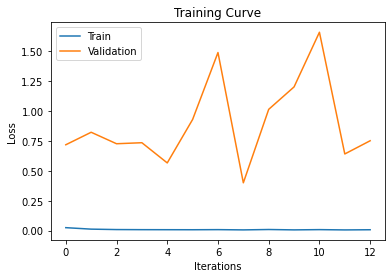

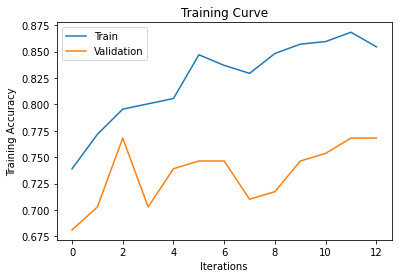

Final Training Accuracy: 0.8544542032622334
Final Validation Accuracy: 0.7681159420289855


In [ ]:
#Convert to the GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
  resnet18 = resnet18.to('cuda:0')
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Batch Size 64
bs = 64
train_loader, val_loader, test_loader = load_aug_data(batch_size=bs)
train(resnet18, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=1)

CUDA is available!  Training on GPU ...
epoch number:  1 Training accuracy:  0.5934755332496863 Validation accuracy:  0.4927536231884058


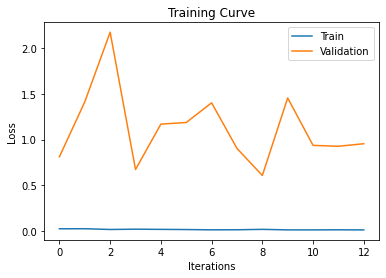

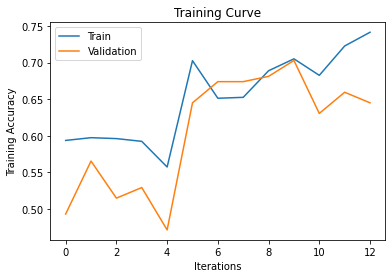

Final Training Accuracy: 0.7415307402760352
Final Validation Accuracy: 0.644927536231884


In [ ]:
#Convert to the GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
  resnet18 = resnet18.to('cuda:0')
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Batch Size 64
bs = 64
train_loader, val_loader, test_loader = load_aug_data(batch_size=bs)
train(resnet18, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=1)

In [ ]:
resnet18_model1 = torchvision.models.resnet18(pretrained=True)
resnet18_model1.fc=torch.nn.Linear(in_features=512, out_features=4)

resnet18_path1 = get_model_name("resnet18", 64, 0.001, 0)
state = torch.load(resnet18_path1)
resnet18_model1.load_state_dict(state)

RuntimeError: ignored

In [ ]:
acc = get_accuracy_mat(resnet18_model1, test_loader)
print("Test Accuracy of resnet18:", acc)

NameError: ignored

### ResNet 50

In [ ]:
resnet50 =torchvision.models.resnet50(pretrained=True)
n_inputs = resnet50.fc.in_features

for param in resnet50.parameters():
  param.requires_grad = False

In [ ]:
resnet50.fc = nn.Sequential(
                      nn.Linear(n_inputs , 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024 , 512),
                      nn.Linear(512 , 4))

In [ ]:
#Convert to the GPU
use_cuda = True
if use_cuda and torch.cuda.is_available():
  resnet50 = resnet50.to('cuda:0')
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

bs = 32
train_loader, val_loader, test_loader = load_aug_data(batch_size=bs)
train(resnet50, train_loader, val_loader, batch_size=32, learning_rate=0.0001, num_epochs=2)

In [ ]:
resnet50_model = torchvision.models.resnet50(pretrained=True)
n_inputs = resnet50_model.fc.in_features

for param in resnet50_model.parameters():
  param.requires_grad = False

resnet50_model.fc = nn.Sequential(
                      nn.Linear(n_inputs , 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024 , 512),
                      nn.Linear(512 , 4))


resnet50_path = get_model_name("resnet50", 32, 0.0001, 1)
state = torch.load(resnet50_path)
resnet50_model.load_state_dict(state)

In [ ]:
acc = get_accuracy_mat(resnet50_model, test_loader)
print("Test Accuracy of resnet50:", acc)

### ResNet 101

In [ ]:
resnet101=torchvision.models.resnet101(pretrained=True)
n_inputs = resnet101.fc.in_features

# Freeze weights
for param in resnet101.parameters():
  param.requires_grad = False

In [ ]:
resnet101.fc = nn.Sequential(
                      nn.Linear(n_inputs , 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024 , 512),
                      nn.Linear(512 , 4))

In [ ]:
#Convert to the GPU
use_cuda = True
if use_cuda and torch.cuda.is_available():
  resnet101 = resnet50.to('cuda:0')
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

bs = 64
train_loader, val_loader, test_loader = load_aug_data(batch_size=bs)
train(resnet101, train_loader, val_loader, batch_size=64, learning_rate=0.0001, num_epochs=2)

In [ ]:
resnet101_model = torchvision.models.resnet101(pretrained=True)
n_inputs = resnet101_model.fc.in_features

for param in resnet101_model.parameters():
  param.requires_grad = False

resnet101_model.fc = nn.Sequential(
                      nn.Linear(n_inputs , 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024 , 512),
                      nn.Linear(512 , 4))


resnet101_path = get_model_name("resnet101", 64, 0.0001, 1)
state = torch.load(resnet101_path)
resnet101_model.load_state_dict(state)

In [ ]:
acc = get_accuracy_mat(resnet101_model, test_loader)
print("Test Accuracy of resnet101:", acc)

In [ ]:
# This is a sample Python script.

# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models
from PIL import Image
import ssl
import streamlit as st
import numpy as np
from torch.autograd import Variable

ssl._create_default_https_context = ssl._create_unverified_context

def import_and_predict(image, model):
        transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor()])

        image = transform(image).unsqueeze(0)
        image = Variable(image)

        prediction = model(image)

        return prediction


mobilenetv3 = torchvision.models.mobilenet_v3_large(pretrained=True)

# add custom layers to prevent overfitting and for finetuning
mobilenetv3.fc = nn.Sequential(nn.Dropout(0.2),
                               nn.BatchNorm1d(1280),  # 320
                               nn.ReLU(),
                               nn.Dropout(0.3),
                               nn.Linear(320, 128),
                               nn.Dropout(0.2),
                               nn.Linear(128, 4),
                               )

state10 = torch.load('/content/gdrive/MyDrive/Training_Results/trial_10_MobileNet_bs_128_lr_001_epoch_4/mobilenet/model_mobilenetv3_bs128_lr0.001_epoch2')
mobilenetv3.load_state_dict(state10)

st.write("""
         # X Ray Image Classification
         """
         )
st.write("This is a simple image classification web app to predict Pneumonia and Covid-19 from X rays")


file = st.file_uploader("Please upload an image file", type=["jpg", "png"])

if file is None:
    st.text("Please upload an X-Ray file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, mobilenetv3)
    _,pred = torch.max(prediction, 1)

    if int(pred[0].numpy()) == 0:
        st.write("Possible Diagnosis: *Covid-19")
    elif int(pred[1].numpy()) == 1:
        st.write("Possible Diagnosis: Normal")
    elif int(pred[2].numpy()) == 2:
        st.write("Possible Diagnosis: Pneumonia-Bacterial")
    elif int(pred[3].numpy()) == 3:
        st.write("Possible Diagnosis: Pneumonia-Viral")

    # st.text("Probability (0: Paper, 1: Rock, 2: Scissor")
    st.write(prediction)




# transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
#                                             torchvision.transforms.ToTensor()])
# image = Image.open('Pneumonia-Viral.jpg')
# print(image)
# image = transform(image).unsqueeze(0)
# print(image.shape)
# 
# mobilenetv3 = torchvision.models.mobilenet_v3_large(pretrained=True)
# 
# # add custom layers to prevent overfitting and for finetuning
# mobilenetv3.fc = nn.Sequential(nn.Dropout(0.2),
#                                nn.BatchNorm1d(1280),  # 320
#                                nn.ReLU(),
#                                nn.Dropout(0.3),
#                                nn.Linear(320, 128),
#                                nn.Dropout(0.2),
#                                nn.Linear(128, 4),
#                                )
# 
# state10 = torch.load('model_mobilenetv3_bs128_lr0.001_epoch2', map_location=torch.device('cpu'))
# mobilenetv3.load_state_dict(state10)
# 
# pred = mobilenetv3(image)
# x = pred.max(1,keepdim=True)[1]
# print(x)


ModuleNotFoundError: ignored